Neural Network

In [22]:
from sklearn.metrics import (matthews_corrcoef, confusion_matrix,
                             classification_report, ConfusionMatrixDisplay)
from joblib import dump
from ucimlrepo import fetch_ucirepo
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential, regularizers, callbacks
from tensorflow.keras.layers import InputLayer, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import utils

covertype = fetch_ucirepo(id=31)

X = covertype.data.features
y = covertype.data.targets

Clean, Balance, and Split Data

In [2]:
# preprocess data using utils.py
X_clean, y_clean = utils.clean_data(X, y)

X_train, X_test, y_train, y_test = utils.split_data(X_clean, y_clean)

# create a validation set
validation_ratio = 0.1

X_train, X_val, y_train, y_val = utils.split_data(X_train, y_train, validation_ratio)

Create Model

In [3]:
# This model will follow the class implementation
model = Sequential([
    InputLayer(input_shape=(54,1)),
    Flatten(),      # ensure our data is flat
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    # Dense(256, activation='relu'),
    # Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(8, activation='softmax')  # 7 categories
])

C:\Users\Kills\miniconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Compile our new model

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [16]:
# Summary of Data
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,800 (444.53 KB)

 Trainable params: 113,800 (444.53 KB)

 Non-trainable params: 0 (0.00 B)

Training of Model

In [17]:
fitted = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=256,
    verbose=1
   # ,callbacks=[early_stopping]
)

Epoch 1/15
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.4874 - loss: 1.2368 - val_accuracy: 0.4876 - val_loss: 1.2260
Epoch 2/15
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4876 - loss: 1.2210 - val_accuracy: 0.4876 - val_loss: 1.2174
Epoch 3/15
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4876 - loss: 1.2143 - val_accuracy: 0.4876 - val_loss: 1.2113
Epoch 4/15
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4876 - loss: 1.2091 - val_accuracy: 0.4876 - val_loss: 1.2076
Epoch 5/15
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4869 - loss: 1.2247 - val_accuracy: 0.4876 - val_loss: 1.2113
Epoch 6/15
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4876 - loss: 1.2102 - val_accuracy: 0.4876 - val_loss: 1.2098
Epoch 7/15
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4876 - loss: 1.2083 - val_accuracy: 0.4876 - val_loss: 1.2086
Epoch 8/15
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.4870 - loss: 1.2224 -

 ## Visualizations

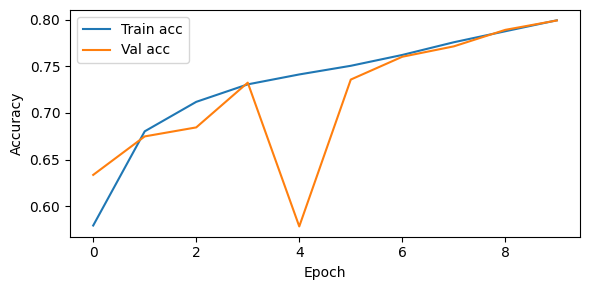

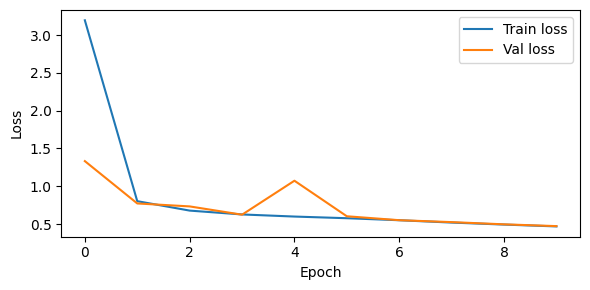

In [14]:
plt.figure(figsize=(6,3))
plt.plot(fitted.history["accuracy"], label="Train acc")
plt.plot(fitted.history["val_accuracy"], label="Val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
plt.plot(fitted.history["loss"], label="Train loss")
plt.plot(fitted.history["val_loss"], label="Val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.tight_layout()
plt.show()

## Results

In [ ]:
# See how our model does on the test set

# TODO: deal with softmax to a prediction and fix model rigidness.
y_predicted = model.predict(X_test)

test_mcc = matthews_corrcoef(y_test, y_predicted)
print("Test MCC:", test_mcc)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_predicted))

ConfusionMatrixDisplay.from_predictions(y_test, y_predicted, cmap="Blues")
plt.show()

In [23]:
# dump model
dump(model, "../data/best_neural_network.joblib")

['../data/best_neural_network.joblib']